<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter16/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git


Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/segment-anything
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [1]:
%cd segment-anything

/content/segment-anything


In [ ]:
%pip install -e .

In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-12-24 12:18:23--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   100MB/s    in 15s     

2023-12-24 12:18:38 (166 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to('cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
help(SamAutomaticMaskGenerator)

Help on class SamAutomaticMaskGenerator in module segment_anything.automatic_mask_generator:

class SamAutomaticMaskGenerator(builtins.object)
 |  SamAutomaticMaskGenerator(model: segment_anything.modeling.sam.Sam, points_per_side: Optional[int] = 32, points_per_batch: int = 64, pred_iou_thresh: float = 0.88, stability_score_thresh: float = 0.95, stability_score_offset: float = 1.0, box_nms_thresh: float = 0.7, crop_n_layers: int = 0, crop_nms_thresh: float = 0.7, crop_overlap_ratio: float = 0.3413333333333333, crop_n_points_downscale_factor: int = 1, point_grids: Optional[List[numpy.ndarray]] = None, min_mask_region_area: int = 0, output_mode: str = 'binary_mask') -> None
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: segment_anything.modeling.sam.Sam, points_per_side: Optional[int] = 32, points_per_batch: int = 64, pred_iou_thresh: float = 0.88, stability_score_thresh: float = 0.95, stability_score_offset: float = 1.0, box_nms_thresh: float = 0.7, crop_n_layers: int = 

In [3]:
predictor = SamPredictor(sam)

In [4]:
image = cv2.imread('/content/segment-anything/notebooks/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [5]:
import numpy as np
input_point = np.array([[500, 375]])
input_label = np.array([1])

In [6]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [7]:
masks.shape

(3, 1200, 1800)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

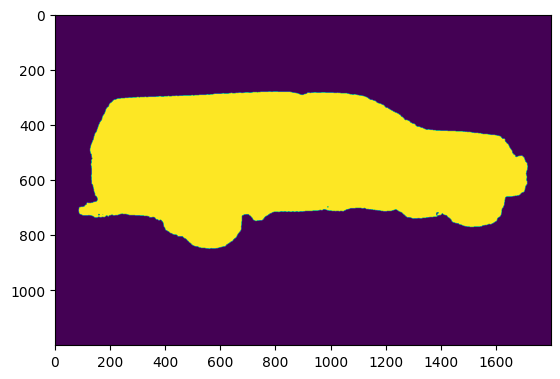

In [9]:
plt.imshow(masks[2])

In [13]:
help(predictor.predict)

Help on method predict in module segment_anything.predictor:

predict(point_coords: Optional[numpy.ndarray] = None, point_labels: Optional[numpy.ndarray] = None, box: Optional[numpy.ndarray] = None, mask_input: Optional[numpy.ndarray] = None, multimask_output: bool = True, return_logits: bool = False) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray] method of segment_anything.predictor.SamPredictor instance
    Predict masks for the given input prompts, using the currently set image.
    
    Arguments:
      point_coords (np.ndarray or None): A Nx2 array of point prompts to the
        model. Each point is in (X,Y) in pixels.
      point_labels (np.ndarray or None): A length N array of labels for the
        point prompts. 1 indicates a foreground point and 0 indicates a
        background point.
      box (np.ndarray or None): A length 4 array given a box prompt to the
        model, in XYXY format.
      mask_input (np.ndarray): A low resolution mask input to the model, typical

In [14]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [16]:
%%time
masks = mask_generator.generate(image)

CPU times: user 4.97 s, sys: 131 ms, total: 5.1 s
Wall time: 5.1 s


In [11]:
input_box = np.array([425, 600, 700, 875])

In [12]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

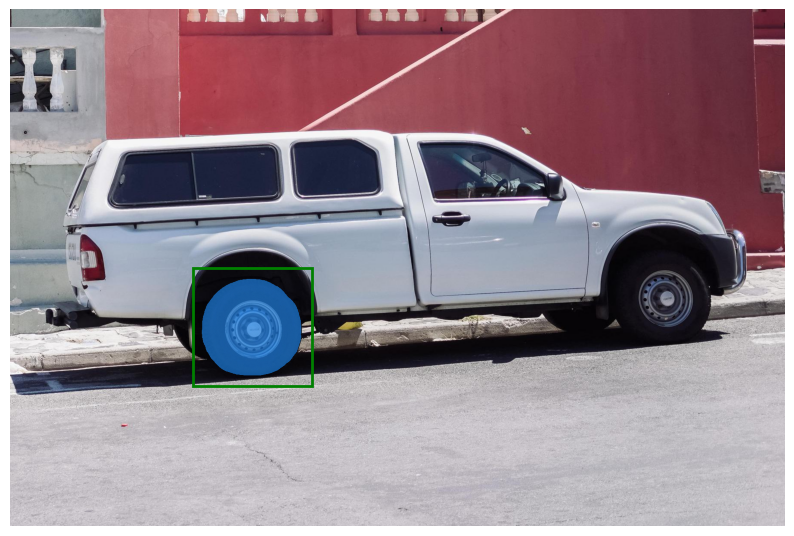

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()